In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset=2**14-dataset-1560
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,4,1,0,2,6,4,0,2,4,4,...,-4,2,9,9,7,5,4,2,4,5
1,4,2,4,-2,0,2,4,2,1,3,...,-4,7,0,2,0,5,4,5,2,4
2,4,4,2,-1,4,0,0,5,1,0,...,4,3,4,4,6,3,1,4,4,3
3,-4,2,6,0,0,2,4,2,0,4,...,0,-2,2,3,4,-4,4,2,1,2
4,1,9,1,3,-3,4,1,0,8,3,...,4,4,1,-4,0,4,0,0,2,-1


Text(0, 0.5, 'bit ADC')

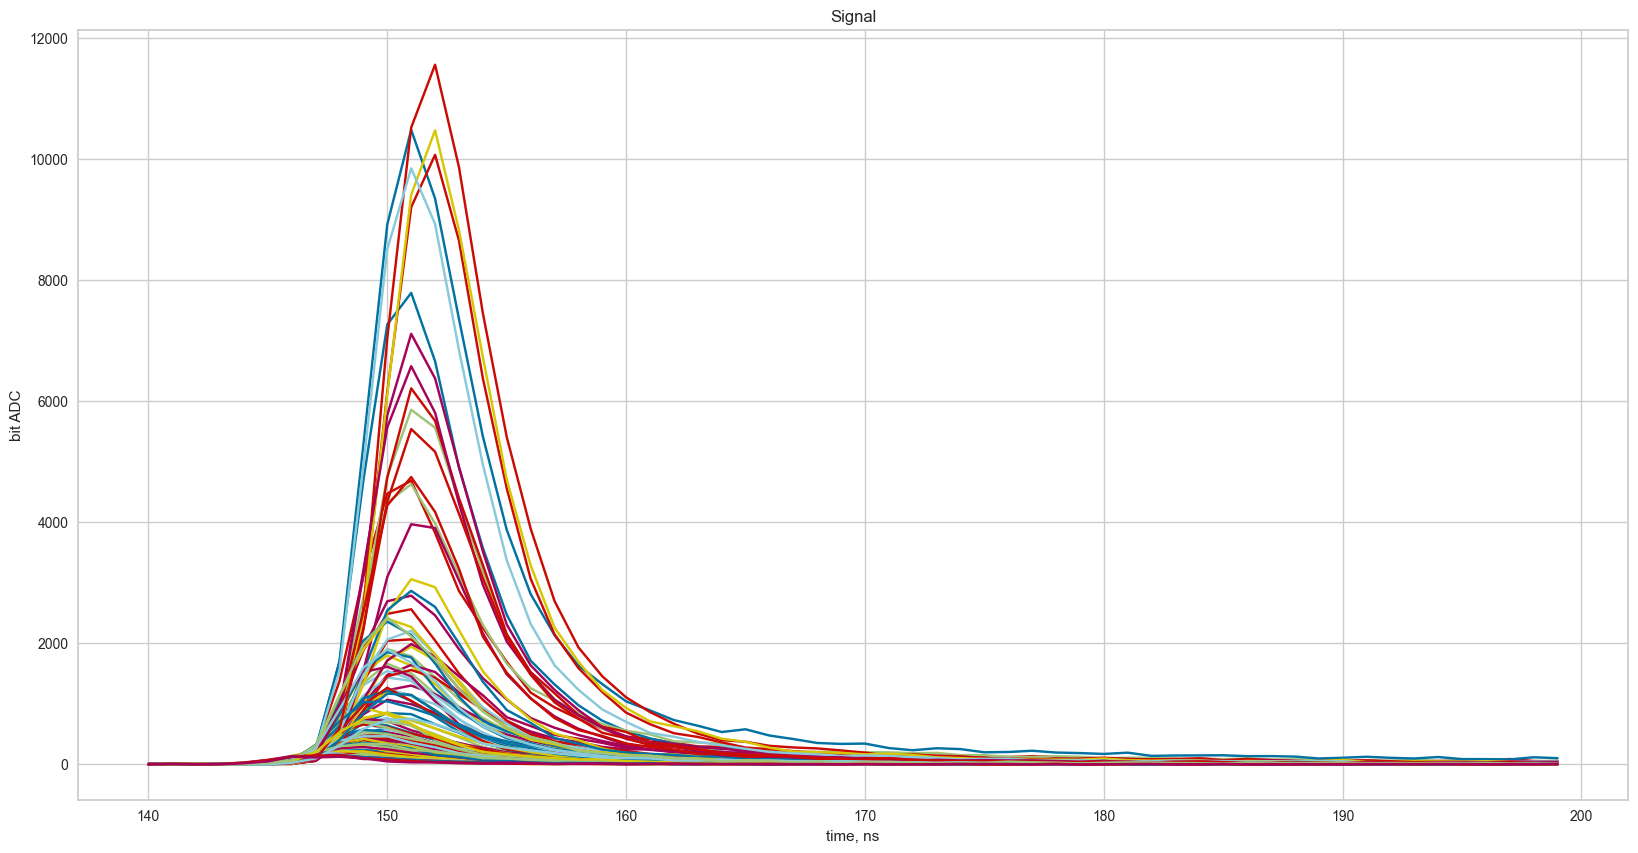

In [4]:
N=range(0,100)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

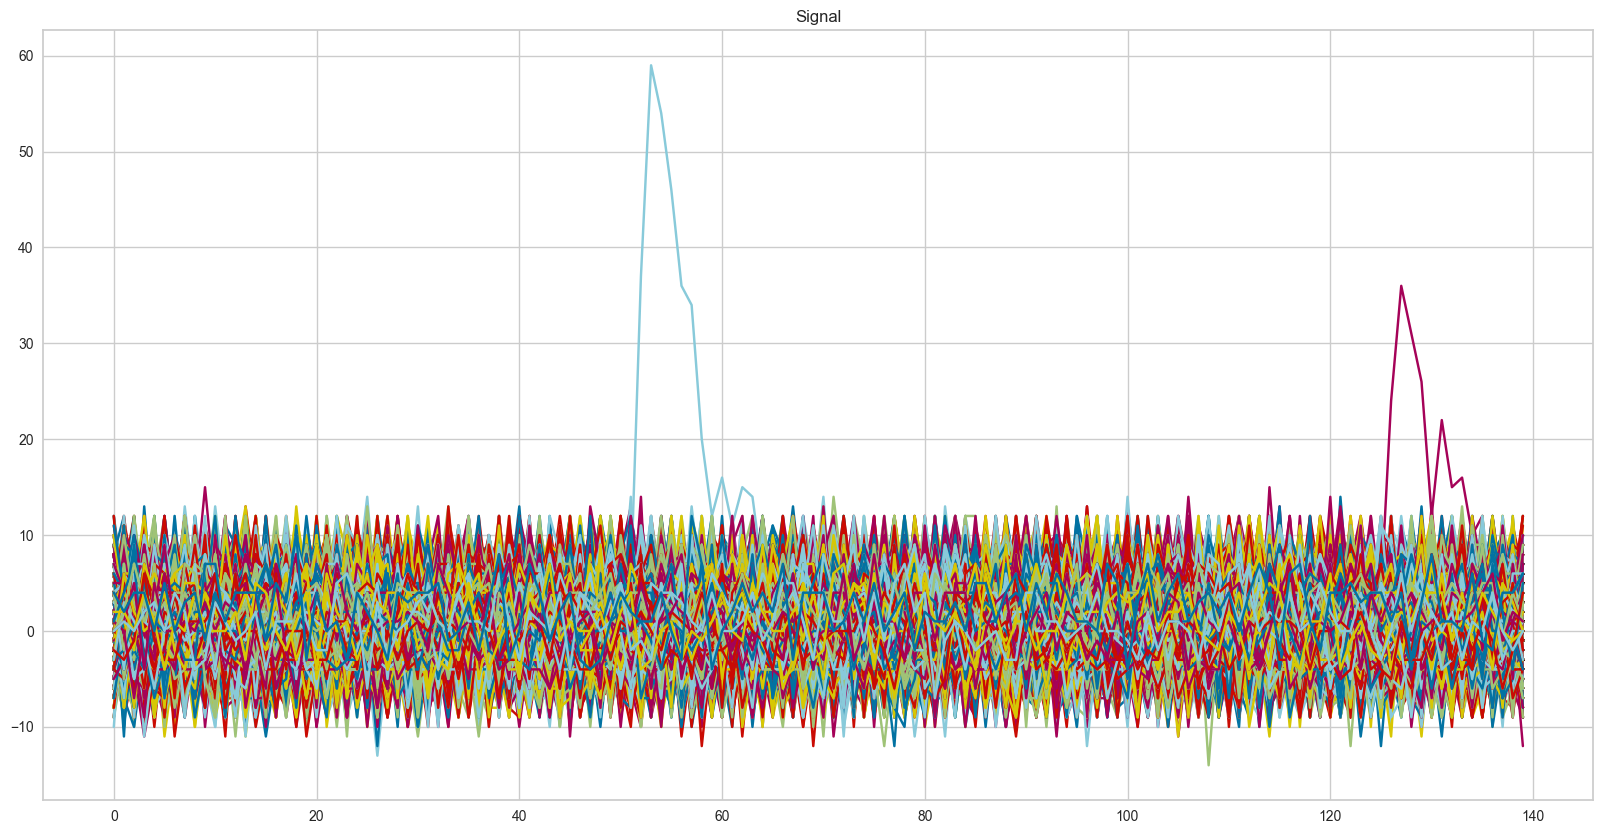

In [12]:
ax = dataset.T[0:140].plot(title='Signal' ,legend=None,figsize=(20,10))

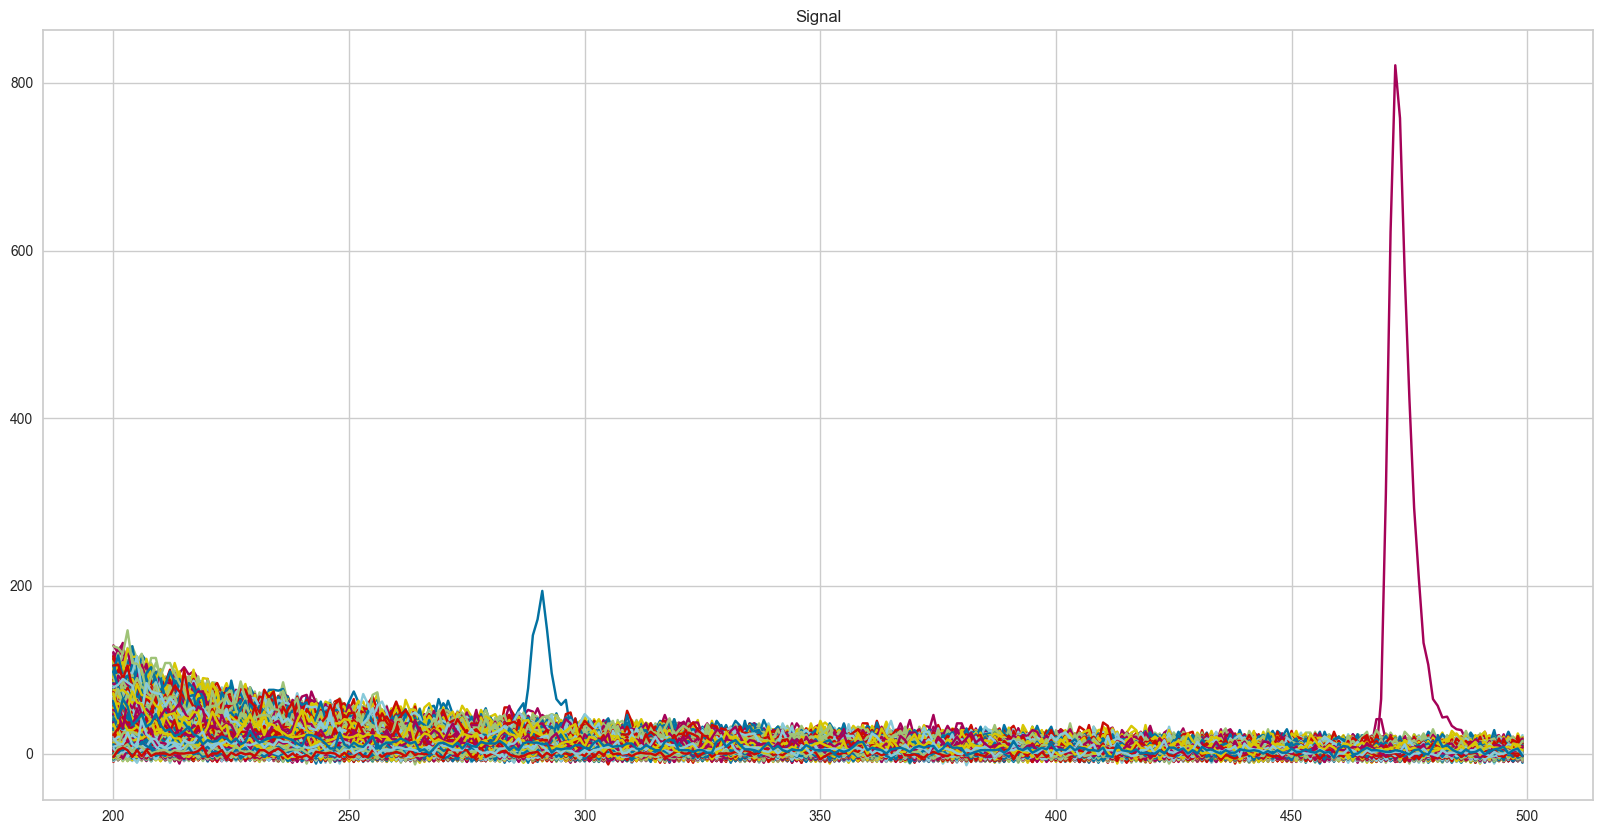

In [13]:
ax = dataset.T[200:500].plot(title='Signal' ,legend=None,figsize=(20,10))

# Обработка данных

In [3]:
# Для начала, необходимо убрать сигналы, которые превышают разрядность АЦП(сигналы с насыщением). Для этого найдем максимальное значение, которое АЦП способен определить и удалим все сигналы, в которых есть это значение
max_value = dataset.values.max()
print(f'Максимальное значение = {max_value}')
plato_filter = dataset[dataset.max(axis=1) == max_value].index

Максимальное значение = 14824


In [4]:
# Далее, нужно отсеять сигналы, которые содержат дополнительные пики. Для левой половины возьмем порог в 30, для правой в 100
peaks_filter = dataset[(dataset.loc[:, 0:140].max(axis=1) > 30) | (dataset.loc[:, 250:500].max(axis=1) > 100)].index

In [5]:
# Составляем общий фильтр
filters = plato_filter.tolist() + peaks_filter.tolist()

# Создание новых признаков

In [6]:
new_dataset = pd.DataFrame()
# Пики
new_dataset['peaks'] = dataset.max(axis=1)
# Площадь под графиком
new_dataset['area'] = np.trapz(dataset, axis=1)
# Время когда наступил пик
new_dataset['peak_timing'] = dataset.idxmax(axis=1)
# Время роста графика
new_dataset['start'] = dataset[dataset.loc[:, 130:170].diff(periods=1, axis='columns') > 80].idxmin(axis=1)
# Если роста не было - заполняем просто peak_timing
new_dataset['start'].fillna(new_dataset['peak_timing'], inplace=True)
# Время спада графика
new_dataset['finish'] = dataset[dataset < 70].fillna(0).astype(bool).loc[:, 150:499].idxmax(axis=1)
# Продолжительность графика
new_dataset['duration'] = new_dataset['finish'] - new_dataset['start']
# Продолжительность роста
new_dataset['increasing_duration'] = new_dataset['peak_timing'] - new_dataset['start']
# Продолжительность спада
new_dataset['decreasing_duration'] = new_dataset['finish'] - new_dataset['peak_timing']

new_dataset['Amplitude'] = new_dataset['peak_timing'] - dataset.idxmin(axis=1)

C:\Users\1\AppData\Local\Temp\ipykernel_23732\1333451694.py:9: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  new_dataset['start'] = dataset[dataset.loc[:, 130:170].diff(periods=1, axis='columns') > 80].idxmin(axis=1)
C:\Users\1\AppData\Local\Temp\ipykernel_23732\1333451694.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_dataset['start'].fillna(new_dataset['peak_timing'], inplace=True)


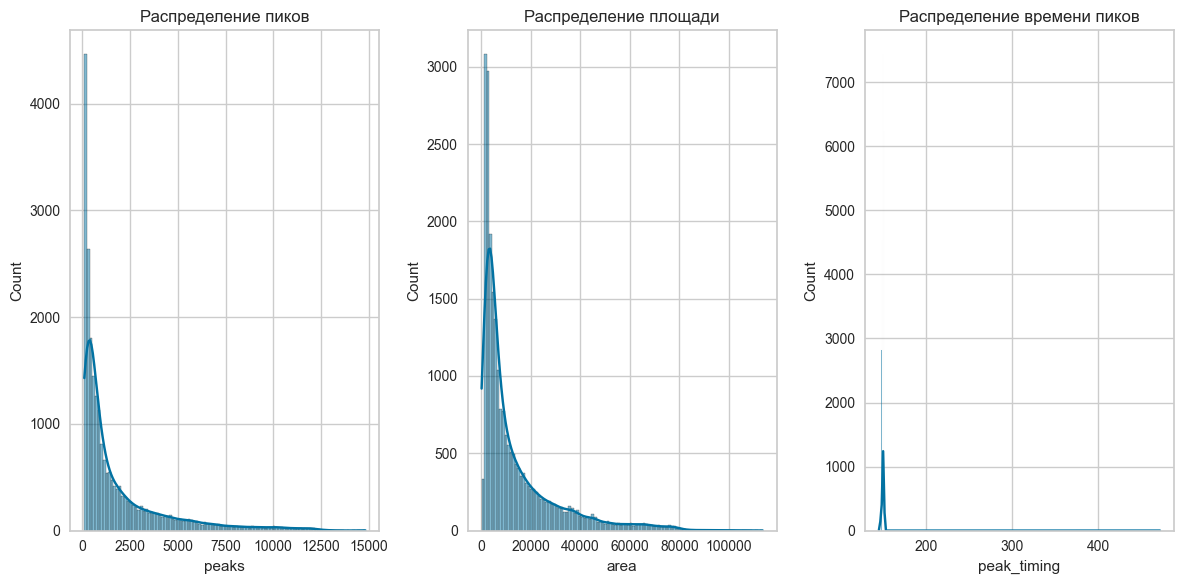

In [ ]:
# Строим графики
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(new_dataset['peaks'], kde=True)
plt.title("Распределение пиков")

plt.subplot(1, 3, 2)
sns.histplot(new_dataset['area'], kde=True)
plt.title("Распределение площади")

plt.subplot(1, 3, 3)
sns.histplot(new_dataset['peak_timing'], kde=True)
plt.title("Распределение времени пиков")

plt.tight_layout()
plt.show()

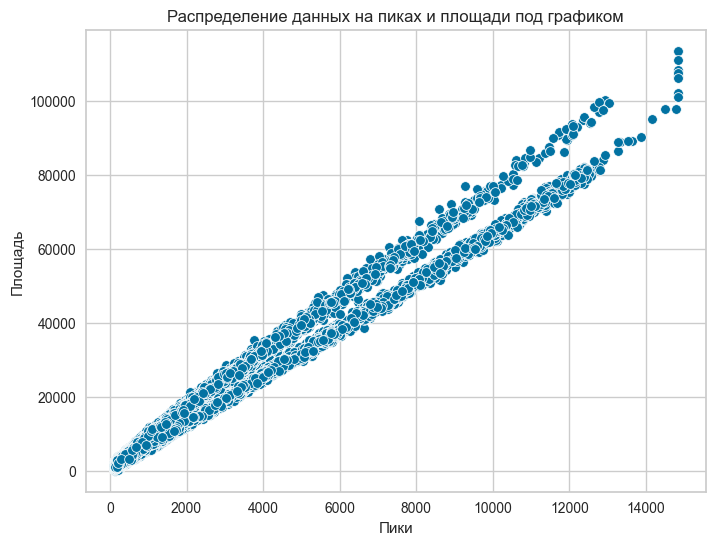

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=new_dataset['peaks'], y=new_dataset['area'])
plt.title("Распределение данных на пиках и площади под графиком")
plt.xlabel('Пики')
plt.ylabel('Площадь')
plt.show()

Распределение данных хорошо отображается на основе пиков и площади под графиком

In [44]:
final_dataset = new_dataset[['area', 'peaks']]

# K-Means

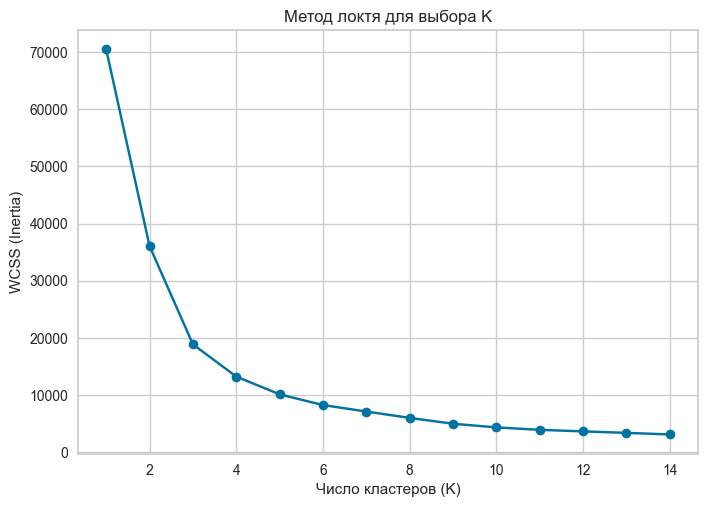

Оптимальное число кластеров по методу локтя: 2
При 2 кластерах, силуэтная оценка составит 0.5583229260808016
При 3 кластерах, силуэтная оценка составит 0.5388905040603088
При 4 кластерах, силуэтная оценка составит 0.542602609473781


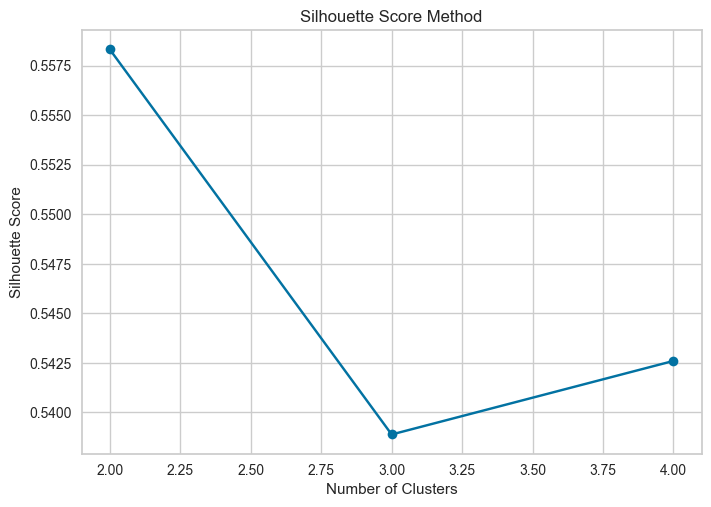

Оптимальное число кластеров по методу силуэта: 2


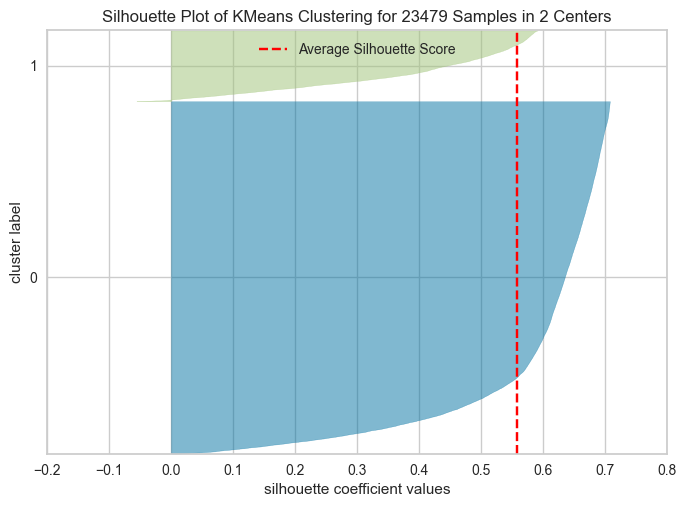

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 23479 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
sd = StandardScaler()
new_dataset_sd = sd.fit_transform(final_dataset)

inertia = []
K_values = range(1, 15)

for k in K_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(new_dataset_sd)
    inertia.append(kmeans.inertia_)

plt.plot(K_values, inertia, marker='o', linestyle='-')
plt.xlabel("Число кластеров (K)")
plt.ylabel("WCSS (Inertia)")
plt.title("Метод локтя для выбора K")
plt.show()

second_derivative = np.diff(inertia, n=2)
if len(second_derivative) > 0:
    optimal_k_elbow = K_values[np.argmax(second_derivative) + 1]
    print(f"Оптимальное число кластеров по методу локтя: {optimal_k_elbow}")

k_values = range(2, 5)

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(new_dataset_sd)
    score = silhouette_score(new_dataset_sd, labels)
    silhouette_scores.append(score)
    print(f'При {k} кластерах, силуэтная оценка составит {score}')

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"Оптимальное число кластеров по методу силуэта: {optimal_k_silhouette}")

model = KMeans(n_clusters=optimal_k_silhouette, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(new_dataset_sd)
visualizer.show()

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_dataset)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

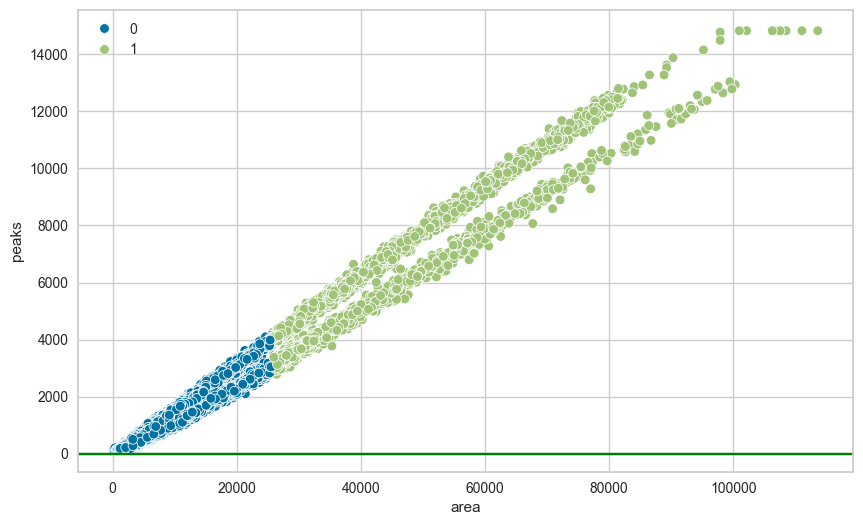

In [38]:
KMeans_df = final_dataset.copy()
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
labels = kmeans.fit_predict(final_dataset)
KMeans_df.loc[:, 'cluster_KMeans'] = labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=KMeans_df, x='area', y='peaks', hue='cluster_KMeans')

plt.axhline(y=0, color='green')
plt.legend()
plt.grid(True)
plt.show()

K-Means плохо показывает себя на разделении, так как стремится разделять данные на сферы или окружности вокруг центроидов.

# HDBSAN

c:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


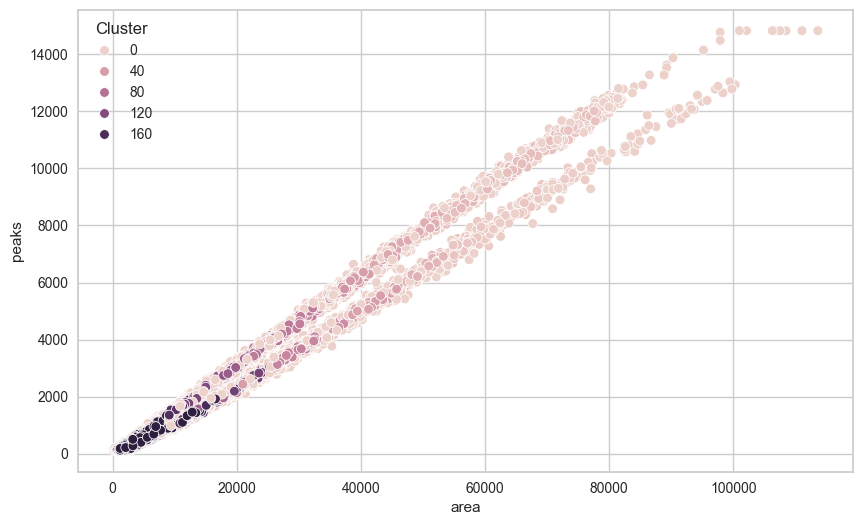

In [26]:
hdbscan_df = final_dataset.copy()
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
labels_hdbscan = clusterer.fit_predict(final_dataset)
hdbscan_df.loc[:, 'cluster_hdbscan'] = labels_hdbscan

plt.figure(figsize=(10, 6))
sns.scatterplot(data=hdbscan_df, x='area', y='peaks', hue='cluster_hdbscan')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

HDBSCAN плохо показывает себя на разделении, так как структуры имеют разную плотность.

# PCA

Применим метод PCA для разделения. Возьмем вторую компоненту и раздлеим данные на две части. Все что будет выше оси x определим в нулевой кластер а остальное в первый.

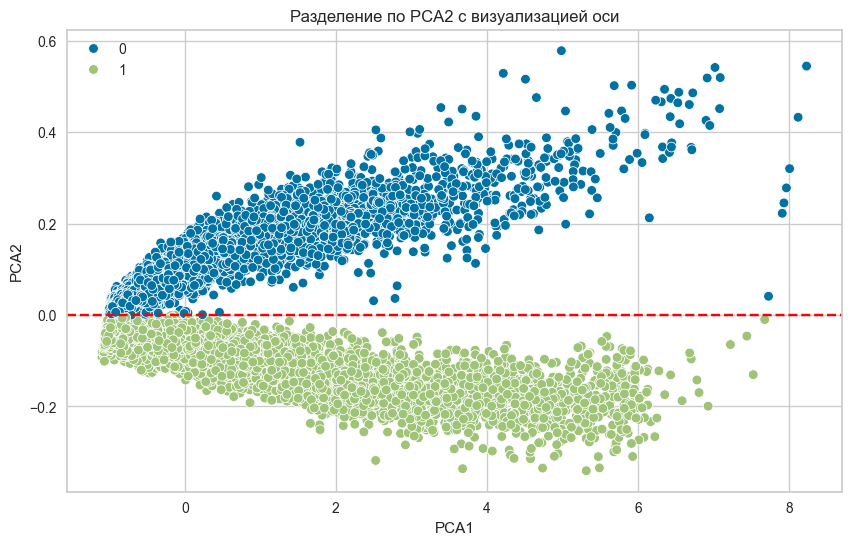

In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_dataset)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

df_pca['cluster'] = (df_pca['PCA2'] < 0).astype(int)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster')

plt.axhline(y=0, color='red', linestyle='--')
plt.title('Разделение по PCA2 с визуализацией оси')
plt.legend()
plt.grid(True)
plt.show()

Как можно увидеть, вторая компонента PCA отлично справляется с разделением данных

In [ ]:
new_dataset.loc[:, 'cluster'] = df_pca['cluster'].values

In [ ]:
# Добавляем 3 кластер
dataset.loc[filters, 'cluster'] = 3

In [ ]:
# Добавляем значения 3 кластера которые получили во втором пункте
new_dataset['cluster'] = dataset['cluster'].combine_first(new_dataset['cluster']).astype(int)

# Сохраняем результаты в файл

In [ ]:
submission = new_dataset.reset_index()[['index', 'cluster']]
submission.columns = ['Index', 'cluster']
submission.to_csv('submission_final.csv', index=False)